курсы акций с разделением полей табуляцией:
6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68
6/20/2014 FB 64.5
6/19/2014 AAPL 91.86
6/19/2014 MSFT 41.51
6/19/2014 FB 64.34

курсы акций с разделением полей двоеточием:
6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68
6/20/2014 FB 64.5

запись курсов акций comma_delimited_stock_prices.txt с разделениме полей запятой
разбор данных в формате json
{'publicationYear': 2014, 'author': 'Joel Grus', 'title': 'Data Science Book', 'topics': ['data', 'science', 'data science']}

Программный интерфейс GitHub
даты [datetime.datetime(2013, 7, 5, 2, 2, 28, tzinfo=tzutc()), datetime.datetime(2013, 11, 15, 5, 33, 22, tzinfo=tzutc()), datetime.datetime(2012, 9, 18, 4, 20, 23, tzinfo=tzutc()), datetime.datetime(2016, 7, 19, 17, 34, 31, tzinfo=tzutc()), datetime.datetime(2015, 11, 11, 14, 15, 36, tzinfo=tzutc()), datetime.datetime(2016, 5, 31, 14, 33, 6, tzinfo=tzutc()), datetime.datetime(2015, 6, 30, 0, 33, 3, tzinfo=tzutc()), datetime.datetime(2013, 8, 21, 13, 26, 5, t

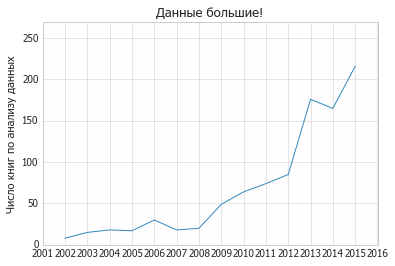

In [1]:
# -*- coding: utf-8 -*-

# getting_data.py

from collections import Counter
import math, random, csv, json, re

# требует предварительной усановки библиотеки BeautifulSoup:
# 1) скачать библиотеку в формате wheel-файла https://pypi.python.org/pypi/beautifulsoup4/, 
# 2) скопировать в C:\Users\[ИМЯ_ПОЛЬЗОВАТЕЛЯ]\Anaconda3\Scripts
# 3) в окне командной строки выполнить pip install beautifulsoup4-4.5.1-py3-none-any.whl,
# где 4-4.5.1 - это версия библиотеки (может быть другой)

from bs4 import BeautifulSoup
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline  

mpl.style.use('ggplot')  
mpl.style.use('seaborn-whitegrid')  
mpl.rcParams['axes.facecolor'] = u'fefefe'
#mpl.rcParams.update({'font.family': 'Ubuntu Condensed'})   
mpl.rcParams.update({'font.family': 'Tahoma'})

######
#
# КНИГИ О ДАННЫХ ИЗДАТЕЛЬСТВА O'Reilly
#
######

# требует установки html5lib  - pip (или pip5) install html5lib
# можно обойтись без установки, если в строке
# BeautifulSoup(requests.get(url).text, parser)  
# для parser использовать 'html.parser' вместо 'html5lib'

# данные на середину янв. 2016 - 42 страницы 
# данные на середину дек. 2015 - 40 страниц 
# данные на момент написания сценария - 31 страница
NUM_PAGES = 42

# предикативная функция-определитель видео
def is_video(td):
    """если элемент имеет только один pricelabel, и текст внутри pricelabel
    без начальных пробелов начинается с 'Video', то значит это видео"""
    pricelabels = td('span', 'pricelabel')
    return (len(pricelabels) == 1 and
            pricelabels[0].text.strip().startswith("Video"))

# информация о книге
def book_info(td):
    """имея на входе объект Tag для <td> библиотеки BeautifulSoup, который 
    обозначает книгу, извлечь описание книги и вернуть словарь dict"""
    title = td.find("div", "thumbheader").a.text
    by_author = td.find('div', 'AuthorName').text
    authors = [x.strip() for x in re.sub("^By ", "", by_author).split(",")]
    isbn_link = td.find("div", "thumbheader").a.get("href")
    
    # re.match захватывает часть текста, соответствующего  
    # регулярному выражению в круглых скобках
    isbn = re.match("/product/(.*)\.do", isbn_link).groups()[0]
    date = td.find("span", "directorydate").text.strip()
    
    return {
        "title" : title,
        "authors" : authors,
        "isbn" : isbn,
        "date" : date
    }

from time import sleep

def scrape(n_pages=NUM_PAGES): 
    base_url = "http://shop.oreilly.com/category/browse-subjects/data.do?sortby=publicationDate&page="

    books = []

    for page_num in range(1, n_pages + 1):
        print ("сбор данных на странице", page_num, ", всего найдено", len(books))
        url = base_url + str(page_num)
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')  # исходно 'html5lib'
            
        for td in soup('td', 'thumbtext'):
            if not is_video(td):
                books.append(book_info(td))

        # как примерные граждане, будем уважать robots.txt!
        sleep(30)  # 30 сек. задержка 

    return books

# получить год
def get_year(book):
    """book["date"] выглядит как 'December 2015', поэтому нужно 
    разбить строку по пробелу и взять вторую часть"""
    return int(book["date"].split()[1])

# хронометраж работы сценария:  
#    num_pages * 
#   (30 сек. задержка + время обработки страницы несколько сек.) 
def plot_years(books):
    fig = plt.figure()
    
    # число лет
    # 2015 год – последний полный год данных (на момент тестирования сценария)   
    year_counts = Counter(get_year(book) for book in books
                          if get_year(book) <= 2015)

    years = sorted(year_counts)
    book_counts = [year_counts[year] for year in years]
    
    plt.plot(years, book_counts, color="#348ABD")

    plt.axis([2001, 2016, 0, 270])
    plt.xticks([2001,2002,2003,2004,2005,2006,
                2007,2008,2009,2010,2011,2012,
                2013,2014,2015,2016])
    #plt.xlabel("Год", fontsize=11)
    plt.ylabel("Число книг по анализу данных", fontsize=11)
    plt.title("Данные большие!", fontsize=13)
    plt.show()
    #fig.savefig("fig_9-1", dpi=300, bbox_inches='tight', facecolor='w') 

    
##
#
# Прикладные программные интерфесы (API)
#
##

# Требует предварительной установки библиотеки twython: pip install twyton

endpoint = "https://api.github.com/users/joelgrus/repos"

repos = json.loads(requests.get(endpoint).text)

from dateutil.parser import parse

dates = [parse(repo["created_at"]) for repo in repos]
month_counts = Counter(date.month for date in dates)
weekday_counts = Counter(date.weekday() for date in dates)

####
#
# Twitter
#
####

from twython import Twython   # требуется предварительная установка pip (pip3) install twython

# Если хотите воспользоваться примером, то присвойте значения нижеследующим константам
CONSUMER_KEY = ""
CONSUMER_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""

def call_twitter_search_api():

    twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

    # поиск твитов, содержащих словосочетание "data science"
    for status in twitter.search(q='"data science"')["statuses"]:
        user = status["user"]["screen_name"].encode('utf-8')
        text = status["text"].encode('utf-8')
        print(user, ":", text)
        print()

from twython import TwythonStreamer

# добавлять данные в глобальную переменную - это пример плохого стиля,
# но он намного упрощает пример
tweets = []

class MyStreamer(TwythonStreamer):
    """наш собственный подкласс класса TwythonStreamer, который
    определяет, как взаимодействовать с потоком"""

    def on_success(self, data):
        """что делать, когда twitter присылает данные?
        здесь данные будут в виде словаря dict, представляющего твит"""

        # нужно собирать твиты только на английском
        if data['lang'] == 'en':
            tweets.append(data)

        # остановиться, когда собрано достаточно
        if len(tweets) >= 1000:
            self.disconnect()

    def on_error(self, status_code, data):
        print(status_code, data)
        self.disconnect()

def call_twitter_streaming_api():
    stream = MyStreamer(CONSUMER_KEY, CONSUMER_SECRET,
                        ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

    # начинает потреблять публичные статусы,
    # которые содержат ключевое слово 'data'
    stream.statuses.filter(track='data')

    # в случае, если напротив нужно начать потреблять ВСЕ публичные статусы
    # stream.statuses.sample()
    

if __name__ == "__main__":

    def process(date, symbol, price):
        print(date, symbol, price)

    print("курсы акций с разделением полей табуляцией:")

    with open('../code-python3-ru/data/tab_delimited_stock_prices.txt', 'r', encoding='utf8',newline='') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            date = row[0]
            symbol = row[1]
            closing_price = float(row[2])
            process(date, symbol, closing_price)

    print()

    print("курсы акций с разделением полей двоеточием:")

    with open('../code-python3-ru/data/colon_delimited_stock_prices.txt', 'r', encoding='utf8',newline='') as f:
        reader = csv.DictReader(f, delimiter=':')
        for row in reader:
            date = row["date"]
            symbol = row["symbol"]
            closing_price = float(row["closing_price"])
            process(date, symbol, closing_price)

    print()

    print("запись курсов акций comma_delimited_stock_prices.txt с разделениме полей запятой")

    today_prices = { 'AAPL' : 90.91, 'MSFT' : 41.68, 'FB' : 64.5 }

    with open('../code-python3-ru/data/comma_delimited_stock_prices.txt','w', encoding='utf8',newline='') as f:
        writer = csv.writer(f, delimiter=',')
        for stock, price in today_prices.items():
            writer.writerow([stock, price])

    print("разбор данных в формате json")
                
    serialized = """{ "title" : "Data Science Book",
                      "author" : "Joel Grus",
                      "publicationYear" : 2014,
                      "topics" : [ "data", "science", "data science"] }"""

    # проанализировать JSON и создать объект Python
    deserialized = json.loads(serialized)
    if "data science" in deserialized["topics"]:
        print(deserialized)

    print()

    print("Программный интерфейс GitHub")
    print("даты", dates)
    print()
    print("количество по месяцам", month_counts)
    print()
    print("количество по дням недели", weekday_counts)

    last_5_repositories = sorted(repos,
                                 key=lambda r: r["created_at"],
                                 reverse=True)[:5]

    print("5 последних языков", [repo["language"]
                                 for repo in last_5_repositories])           
    
    print()
    plot_years(scrape())  # 42 страницы книг на янв 2016    

In [ ]:
print("BeautifulSoup")
html = requests.get("https://www.python.org/").text
soup = BeautifulSoup(html, 'html.parser')   #UPD в оригинале 'html5lib'
print(soup)